# CZ gate coherent error benchmarking

In [1]:
import sys

sys.path.append(
    "/Users/tport/miniconda3/envs/basic_scientific/lib/python3.13/site-packages"
)

# MIT Results

## Wrapper function

In [2]:
import numpy as np
from typing import Any, Callable, Literal
from components import DeviceCharacteristics
from fidelity_optimization import find_best_fit

angle_bound = (-0.1, 0.1)  # radians
timescale_bound = (10, 1000)  # timescale is in terms of the gate time.
spam_bound = (0, 1)


def init_device_characteristics():
    """Create a new DeviceCharacteristics instance with all elements initialized as
    tuples.
    """
    return DeviceCharacteristics(
        {
            "T1_1": timescale_bound,
            "T1_2": timescale_bound,
            "T2_1": timescale_bound,
            "T2_2": timescale_bound,
            "ZZ": angle_bound,
            "ZI": angle_bound,
            "IZ": angle_bound,
            "infinite_time_spam": spam_bound,
            "zero_time_spam": spam_bound,
        }
    )


def extract_params(
    state: Literal["00", "01", "10", "11", "0+", "+0", "++"],
    pulse_sequence: Literal["II", "XI", "IX", "XX"],
    x_data: np.ndarray,
    y_data: np.ndarray,
    opt: Literal["global", "minimize", "curve", "least_squares"] = "global",
    y_err: np.ndarray | None = None,
    initial_guess: list[Any] | None = None,
) -> tuple[dict[str, Any], list[Any], Callable]:
    """
    Args:
        state: initial state of the experiment. Can be one of ["00", "01", "10", "11", "0+", "+0", "++"]
        pulse_sequence: the sequence of X pulses applied. Can be one of ["II", "XI", "IX", "XX"]
        x_data: sequence of number of gates applied. Each element should be an `int` divisible by 4.
        y_data: the series data of fidelity
        opt: the underlying optimization method to use. The default is scipy global optimization (differential evolution)
    """
    device = init_device_characteristics()
    match state:
        case "00":
            device.update_dict(
                {"T1_1": np.inf, "T1_2": np.inf, "T2_1": np.inf, "T2_2": np.inf}
            )
            raise ValueError("Fit function does not yield useful info.")
        case "01":
            device.update_dict({"T1_1": np.inf, "T2_1": np.inf, "T2_2": np.inf})
            raise ValueError("Fit function does not yield useful info.")
        case "10":
            device.update_dict({"T1_2": np.inf, "T2_1": np.inf, "T2_2": np.inf})
            raise ValueError("Fit function does not yield useful info.")
        case "0+":
            device.update_dict({"T1_1": np.inf, "T2_1": np.inf, "T1_2": np.inf})
        case "+0":
            device.update_dict({"T1_1": np.inf, "T1_2": np.inf, "T2_2": np.inf})
        case "++":
            pass
    match pulse_sequence:
        case "II":
            pass
        case "XX":
            # DD on first qubit. Only ZZ term remains unaffected.
            device.update_dict({"ZI": -np.pi / 4, "IZ": -np.pi / 4})
        case "XI":
            # DD on first qubit. Only IZ term remains unaffected.
            device.update_dict({"ZZ": -np.pi / 4, "ZI": -np.pi / 4})
        case "IX":
            # DD on second qubit. Only ZI term remains unaffected.
            device.update_dict({"IZ": -np.pi / 4, "ZZ": -np.pi / 4})

    keys = device.get_optimizee_keys()
    if initial_guess is None:
        initial_guess = []
        for key in keys:
            if key.startswith("T"):
                # Decay timescale params
                initial_guess.append(230)
            elif key.endswith("spam"):
                # SPAM params
                initial_guess.append(1)
            else:
                # Angle params
                initial_guess.append(-0.01)

    exp_literal = state
    optim_params, _, _, func = find_best_fit(
        exp_literal, x_data, y_data, device, initial_guess, opt=opt, y_err=y_err
    )
    result_dict = {keys[i]: optim_params[i] for i in range(len(keys))}
    return result_dict, optim_params, func

## Import Data

The result of i-th experiment (entire circuit, with preparation and unpreparation) as stored as follows:

* `pop_00[i, t]` = P(00 measurement after evolving till t in i-th experiment)
* `pop_01[i, t]` = P(01 measurement after evolving till t in i-th experiment)
* `pop_10[i, t]` = P(10 measurement after evolving till t in i-th experiment)
* `pop_11[i, t]` = P(11 measurement after evolving till t in i-th experiment)
* `pop_qb1[i, t]` = P(1* measurement after evolving till t in i-th experiment)
* `pop_qb2[i, t]` = P(*1 measurement after evolving till t in i-th experiment)

The experiments are numbered as follows (indexing from 0):
* 0th - initial state 00
* 1st - initial state 11
* 2nd - initial state ++, pulse sequence XX
* 3rd - initial state +0, pulse sequence IX
* 4th - initial state 0+, pulse sequence XI
* 5th - initial state +0, pulse sequence XX
* 6th - initial state 0+, pulse sequence XX

In [3]:
import numpy as np

"""
TODO (Junyoung): Update the path to the pop_00 file
"""
folder = "25-07-04"
pop_00 = np.load(f"{folder}/pop_00_vs_exp.npy")
n_cz = np.array([4 * i for i in range(len(pop_00[0]))])

# n_cz = np.load(f"{folder}/num_cz_gates.npy");
# pop_01 = np.load(f"{folder}/pop_01_vs_exp.npy");
# pop_10 = np.load(f"{folder}/pop_10_vs_exp.npy");
# pop_11 = np.load(f"{folder}/pop_11_vs_exp.npy");
# pop_qb1 = np.load(f"{folder}/pop_QB1_vs_exp.npy");
# pop_qb2 = np.load(f"{folder}/pop_QB2_vs_exp.npy");

sigma_00 = np.sqrt(pop_00 * (1 - pop_00) / 1000)
T1_1 = 50  # microseconds
T1_2 = 25  # microseconds
T2_1 = 40  # microseconds
T2_2 = 4  # microseconds

tg_X = 0.030 + 0.010  # microseconds
tg_cz = 0.070 + 0.010;  # microseconds

In [4]:
pop_00.shape

(9, 31)

In [5]:
class Exp:
    def __init__(self, state, pulse, index):
        self.state = state
        self.pulse = pulse
        self.index = index


"""
TODO (Junyoung): Update the list so that the order matches the raw data
"""
exp_list = [
    # # 25-06-19 definitions
    # NO_DD_00 = 0
    # NO_DD_11 = 1
    # DD_PP_XX = 2
    # DD_P0_IX = 3
    # DD_0P_XI = 4
    # DD_P0_XX = 5
    # DD_0P_XX = 6
    
    # 25-07-04 definitions
    Exp("00", "II", 0),
    Exp("11", "II", 1),
    Exp("++", "XX", 2),
    Exp("+0", "IX", 3),
    Exp("0+", "XI", 4),
    Exp("+0", "XX", 5),
    Exp("0+", "XX", 6),
    Exp("+0", "II", 7),
    Exp("0+", "II", 8),
]

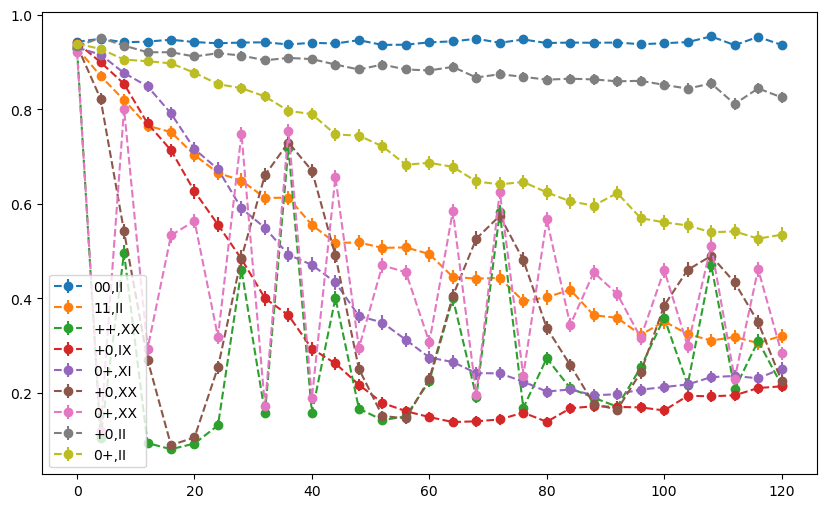

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

###### NOTE: Label #3 (++,XX) is doubtful.
for i in range(len(exp_list)):
    plt.errorbar(
        n_cz,
        pop_00[i, :],
        sigma_00[i, :],
        linestyle="--",
        marker="o",
        label=f"{exp_list[i].state},{exp_list[i].pulse}",
    )
plt.legend()
plt.show()

## Run Analysis

### Compile fits
Gather the fit data for each of the experiments we ran, and print the results.

In [7]:
optim_params_list = []
func_params_list = []
func_list = []
for i, exp in enumerate(exp_list):
    if exp.state in ["00", "11"]:
        optim_params_list.append(None)
        func_params_list.append(None)
        func_list.append(None)
        continue
    y_data = pop_00[i, :]
    y_err = pop_00[i, :]
    x_data = n_cz

    optim_params, func_params, func = extract_params(
        exp.state, exp.pulse, x_data, y_data, opt="global"
    )

    optim_params_list.append(optim_params)
    func_params_list.append(func_params)
    func_list.append(func)

    print(f"From {exp.state}, {exp.pulse} experiment: ")
    optim_y = func(x_data, *func_params)
    print("RMSE Error:", np.sum(np.abs(optim_y - y_data) ** 2))
    # print(optim_params)
    for key, value in optim_params.items():
        if key.startswith("T"):
            print(f"{key}: {value} * tg")
        elif "Z" in key:
            print(f"{key}: {value * 180 / np.pi} degrees")
    print()


From ++, XX experiment: 
RMSE Error: 0.31782025743046244
T1_1: 696.3486237231624 * tg
T1_2: 33.9422940858132 * tg
T2_1: 11.976418410266298 * tg
T2_2: 928.5361892964954 * tg
ZZ: 5.000037688284839 degrees

From +0, IX experiment: 
RMSE Error: 0.006974436163140706
T2_1: 186.74652818184904 * tg
ZI: 0.2507577822436372 degrees

From 0+, XI experiment: 
RMSE Error: 0.0041220915467656515
T2_2: 264.70628295196474 * tg
IZ: 0.21600270491441836 degrees

From +0, XX experiment: 
RMSE Error: 0.09389939614821534
T2_1: 331.5990156919461 * tg
ZZ: 1.25285354507096 degrees

From 0+, XX experiment: 
RMSE Error: 0.06685090725271287
T2_2: 360.8800370991474 * tg
ZZ: 5.005408164603235 degrees

From +0, II experiment: 
RMSE Error: 0.0020208688080377538
T2_1: 735.4901417729252 * tg
ZZ: -0.8241590102296912 degrees
ZI: 0.8749993599073042 degrees
IZ: -0.07035267336090456 degrees

From 0+, II experiment: 
RMSE Error: 0.003895518767482019
T2_2: 460.9507976028651 * tg
ZZ: -4.939715192800598 degrees
ZI: -4.50609614263

In [8]:
T2E_1 = 60  # microseconds
T2E_2 = 25  # microseconds

tg_X = 0.030 + 0.010  # microseconds
tg_cz = 0.070 + 0.010  # microseconds

print("Actual timescales")
print("\tQubit 1\t\t\tQubit 2")
print(f"T1\t{T1_1 / (tg_X + tg_cz)}\t{T1_2 / (tg_X + tg_cz)}")
print(f"T2\t{T2_1 / (tg_X + tg_cz)}\t{T2_2 / (tg_X + tg_cz)}")
print(f"T2E\t{T2E_1 / (tg_X + tg_cz)}\t\t{T2E_2 / (tg_X + tg_cz)}")


Actual timescales
	Qubit 1			Qubit 2
T1	416.6666666666667	208.33333333333334
T2	333.33333333333337	33.333333333333336
T2E	500.0		208.33333333333334


### Plot
Plot and compare the fit to the actual data.

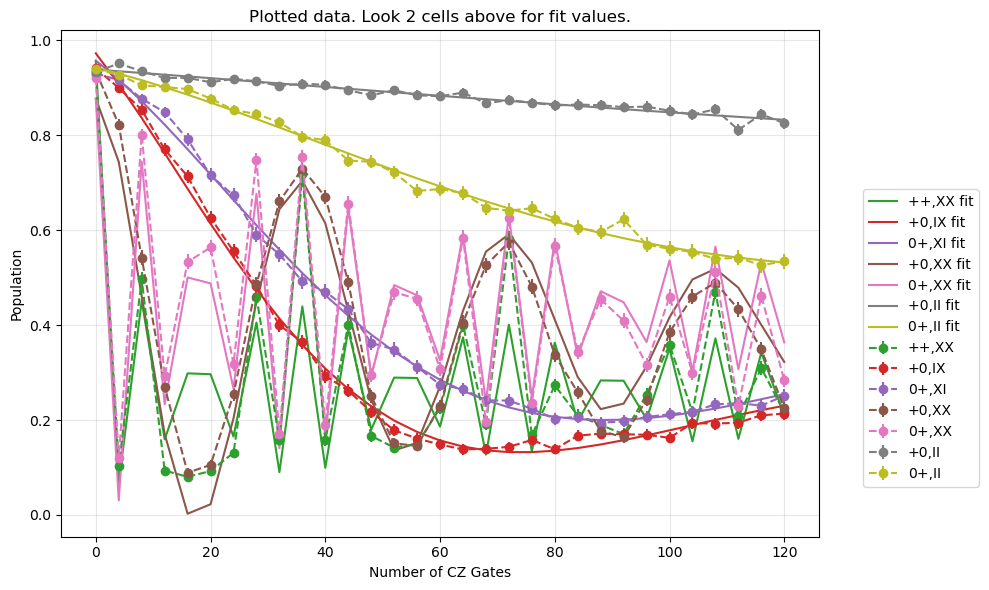

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Define colors for each group (e.g., 3 colors for 3 groups)
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
]

# Data curves
for i, exp in enumerate(exp_list):
    if exp.state in ["00", "11"]:
        continue
    y_data = pop_00[i, :]
    y_err = pop_00[i, :]
    x_data = n_cz
    plt.errorbar(
        n_cz,
        pop_00[i, :],
        sigma_00[i, :],
        linestyle="--",
        marker="o",
        label=f"{exp_list[i].state},{exp_list[i].pulse}",
        color=colors[i],
    )

    # Fit curves (use the same color as the corresponding data curve)
    t = np.linspace(0, x_data[-1], num=int(x_data[-1] / 4) * 1 + 1)
    plt.plot(
        t,
        func_list[i](t, *func_params_list[i]),
        label=f"{exp_list[i].state},{exp_list[i].pulse} fit",
        color=colors[i],
        marker="",
    )
    # plt.plot(t, func_0P_XX(t, *func_params_0P_XX), label='0+ XX, fit', color=colors[3], marker='^')
    # plt.plot(t, func_P0_XX(t, *func_params_P0_XX), label='+0 XX, fit', color=colors[4], marker='^')

plt.xlabel("Number of CZ Gates")
plt.ylabel("Population")
plt.title("Plotted data. Look 2 cells above for fit values.")

plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc="upper left")
plt.tight_layout()
plt.show()